## Load a MERSCOPE experiment

In [1]:
import os
import glob
from pathlib import Path

from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation, disk
from skimage.segmentation import find_boundaries
from tqdm.notebook import tqdm

import sawg.segmentation

/home/madeleine.hewitt/miniconda3/envs/seg_demo/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/madeleine.hewitt/miniconda3/envs/seg_demo/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/madeleine.hewitt/miniconda3/envs/seg_d

In [2]:
def get_cell_cmap(spot_table, bg_color: str|None = None, remove_negatives: bool = True):
    # Create colormap for cell ids
    cell_ids = np.unique(spot_table.cell_ids)
    cell_colors = spot_table.cell_palette(spot_table.cell_ids)

    if remove_negatives:
        # Remove the negative values in cell_palette, which can throw off visualization
        cell_colors = {cell: color for cell, color in cell_colors.items() if cell in cell_ids}

    if bg_color is not None:
        cell_colors[0] = colors.to_rgba(bg_color)

    cell_cmap = colors.ListedColormap(cell_colors.values())

    return cell_cmap

In [3]:
expt_path = '/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/data/mouse_658850_testdata_image12/region_0/'
image_path = expt_path + 'images/'
csv_file = expt_path + 'detected_transcripts.csv'
cache_file = '/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/data/cache_files/mouse_658850_testdata_image12_detected_transcripts.csv.npz'

max_rows = None
table = sawg.SpotTable.load_merscope(csv_file=csv_file, cache_file=cache_file, image_path=image_path, max_rows=max_rows)

Loading from npz..


## Pick a small tile to test on

We will use a region of high cell density to demonstrate the improvement of the custom model over pretrained Cellpose models.

In [4]:
subrgn = np.array([[4605.0, 4805.0], [3032.0, 3232.0]])
subtable = table.get_subregion(xlim=subrgn[0], ylim=subrgn[1])

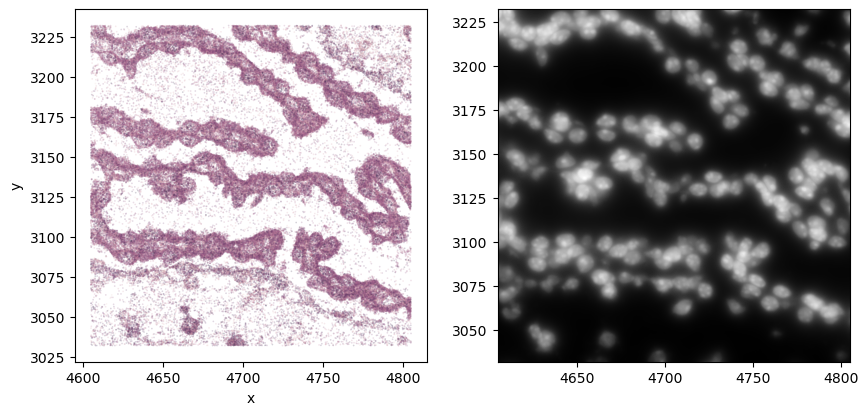

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
subtable.scatter_plot(ax=ax[0])
subtable.get_image(channel='DAPI').show(ax=ax[1], frame='mean', cmap='gray')

## Choose a custom Cellpose model for segmentation

#### Currently available finetuned models:

- `cellpose_20230919_3species_merscope`: cyto model for total_mrna + nuclei, finetuned on 9 MERSCOPE images (3 each of human, macaque and mouse) done in 2D using various z planes (NOTE: as of 10/20/2023, this is currently the preferred model for MERSCOPE images)
- `cellpose_20230908_mouse_merscope`: cyto2 model for total_mrna + nuclei, finetuned on 10 mouse MERSCOPE images in 2D, using various z planes
- `cellpose_20230915_macaque_stereoseq`

In [6]:
model_name = 'cellpose_20230919_3species_merscope'
custom_model_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/mFISH/spatial_bioinformatics/models/'
path_to_model = os.path.join(custom_model_dir, model_name)

## Use custom model to segment a single (2D) slice

Note: if running segmentation on a two channel image, you must specify the frame for both channels.

In [7]:
seg_custom_2d = sawg.segmentation.CellposeSegmentationMethod(options={
    'region': None,
    'cellpose_model': path_to_model, # path (to custom model) or string (for pretrained model, e.g. 'cyto2')
    'cellpose_gpu': True,
    'px_size': 0.108,          # um / px
    'cell_dia': 10,            # um (or None)
    'z_plane_thickness': 1.5,  # um
    'images': {
        'nuclei': {'channel': 'DAPI', 'frame': 3},
        'cyto': {'channel': 'total_mrna', 'frame': 3}
    }, 
    'cellpose_options': {
        'batch_size': 8,
    }
})
result_custom_2d = seg_custom_2d.run(subtable)

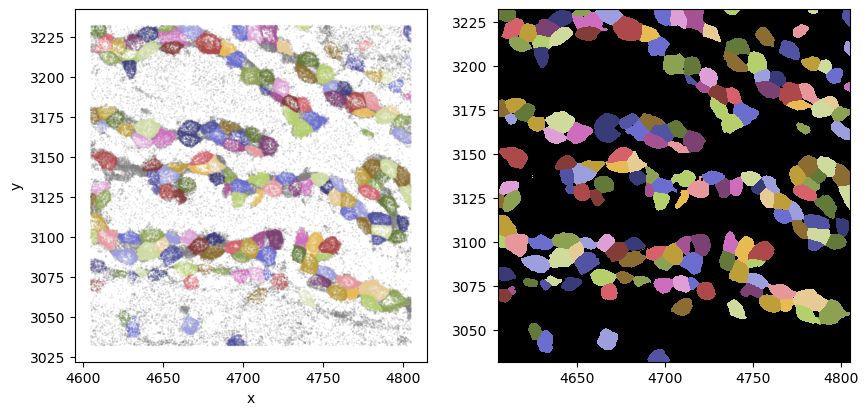

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Create colormap for cell ids
cmap_custom_2d = get_cell_cmap(result_custom_2d.spot_table(), bg_color='black')

result_custom_2d.spot_table().scatter_plot(ax=ax[0], color='cell')
result_custom_2d.mask_image.show(ax[1], cmap=cmap_custom_2d, interpolation='None')

## Compare to results of a pretrained Cellpose model

In [9]:
seg_cyto_2d = sawg.segmentation.CellposeSegmentationMethod(options={
    'region': None,
    'cellpose_model': 'cyto2',
    'cellpose_gpu': True,
    'px_size': 0.108,          # um / px
    'cell_dia': 10,            # um (or None)
    'z_plane_thickness': 1.5,  # um
    'images': {
        'nuclei': {'channel': 'DAPI', 'frame': 3},
        'cyto': {'channel': 'total_mrna', 'frame': 3}
    }, 
    'cellpose_options': {
        'batch_size': 8,
    }
})
result_cyto_2d = seg_cyto_2d.run(subtable)

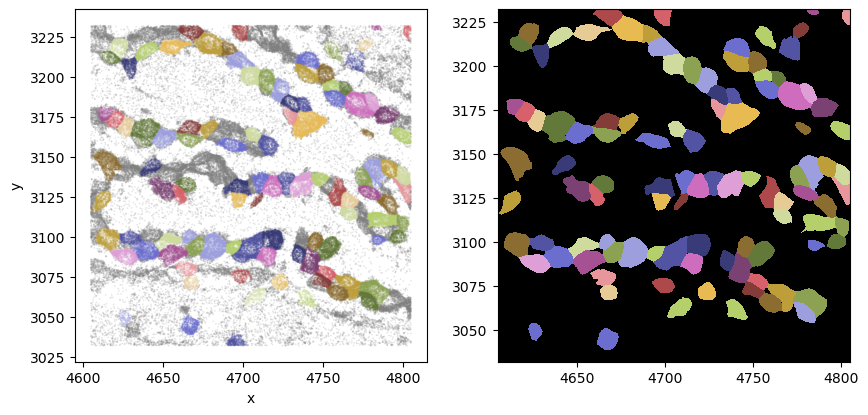

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Create colormap for cell ids
cmap_cyto_2d = get_cell_cmap(result_cyto_2d.spot_table(), bg_color='black')

result_cyto_2d.spot_table().scatter_plot(ax=ax[0], color='cell')
result_cyto_2d.mask_image.show(ax[1], cmap=cmap_cyto_2d, interpolation='None')

## Side-by-side comparison of two models

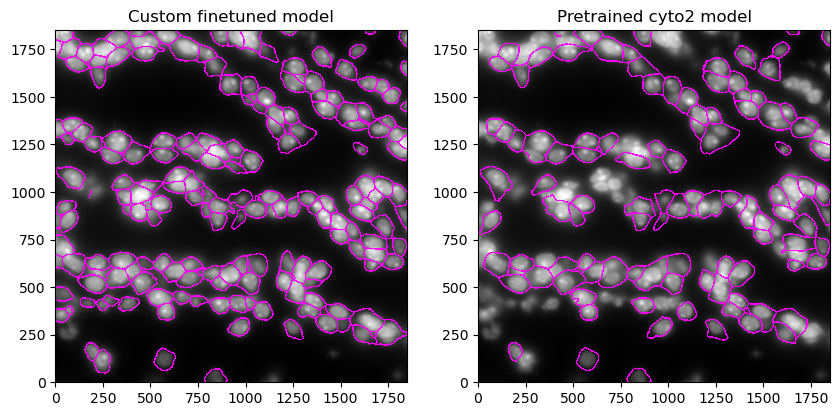

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Make a custom colormap where 0 is transparent
cmap_transparent0 = colors.ListedColormap(['none', 'magenta'])

cyto_outlines = dilation(find_boundaries(result_cyto_2d.mask_image.get_data()[0, ...]), footprint=disk(3))
custom_outlines = dilation(find_boundaries(result_custom_2d.mask_image.get_data()[0, ...]), footprint=disk(3))

ax[0].imshow(subtable.get_image(channel='DAPI').get_frame(3).get_data()[0, ...], cmap='gray')
ax[0].imshow(custom_outlines, cmap=cmap_transparent0, interpolation='nearest')
ax[0].invert_yaxis()
ax[0].set_title('Custom finetuned model')

ax[1].imshow(subtable.get_image(channel='DAPI').get_frame(3).get_data()[0, ...], cmap='gray')
ax[1].imshow(cyto_outlines, cmap=cmap_transparent0, interpolation='nearest')
ax[1].invert_yaxis()
ax[1].set_title('Pretrained cyto2 model')

plt.show()

## Run custom Cellpose on a 3D stack

Omit the frame argument to run 3D segmentation.

Note: 3D Cellpose segmentation can be very slow without GPU access.

In [12]:
seg_custom_3d = sawg.segmentation.CellposeSegmentationMethod(options={
    'region': None,
    'cellpose_model': path_to_model,
    'cellpose_gpu': True,
    'px_size': 0.108,          # um / px
    'cell_dia': 10,            # um (or None)
    'z_plane_thickness': 1.5,  # um
    'images': {
        'nuclei': {'channel': 'DAPI'},
        'cyto': {'channel': 'total_mrna'}
    }, 
    'cellpose_options': {
        'batch_size': 8,
    }
})
result_custom_3d = seg_custom_3d.run(subtable)

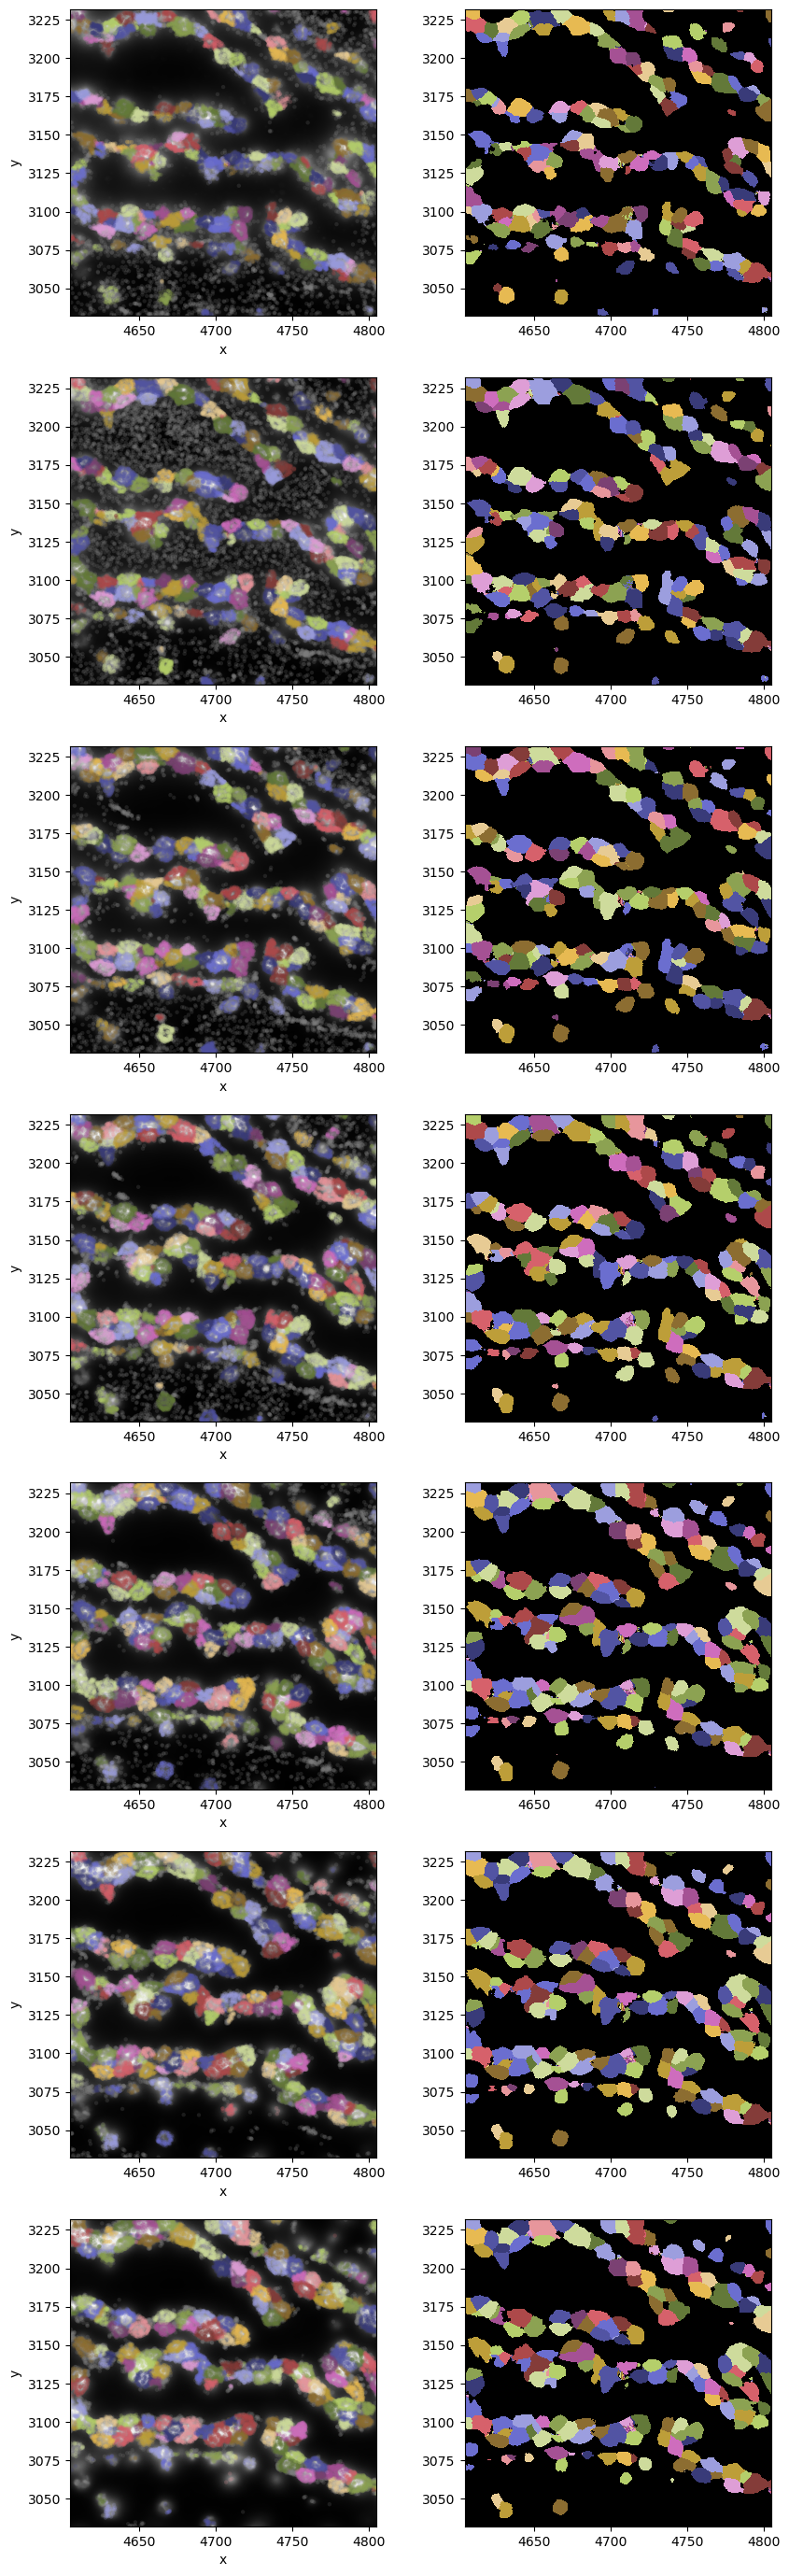

In [14]:
img = subtable.get_image(channel='DAPI')
n_planes = img.shape[0]

fig, ax = plt.subplots(n_planes, 2, figsize=(10, 5*n_planes))

# Create colormap for cell ids
cmap_custom_3d = get_cell_cmap(result_custom_3d.spot_table(), bg_color='black')

for i in range(n_planes):
    mask = subtable.z == i
    result_custom_3d.spot_table()[mask].scatter_plot(ax=ax[i, 0], color='cell', size=10)
    
    img_layer = img.get_frame(i)
    img_layer.show(ax[i, 0], cmap='gray')
    mask_layer = result_custom_3d.mask_image.get_frame(i)
    mask_layer.show(ax[i, 1], cmap=cmap_custom_3d, interpolation='None')

## Run custom Cellpose on a whole section using the hpc

In [15]:
# define output paths
output_dir = '/allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/seg_tests/mouse_658850_testdata_image12/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

tile_save_path = os.path.join(output_dir, 'segmentation/')
segmentation_file = os.path.join(output_dir, 'segmentation.npy')
anndata_file = os.path.join(output_dir, 'cell_by_gene.h5ad')
job_path = os.path.join(output_dir, 'hpc-jobs')
if not os.path.exists(job_path):
    os.mkdir(job_path)

In [16]:
# For test run, use a subregion
subrgn = np.array([[4000, 5000], [2500, 3500]])

# For full run, pick everything backed by DAPI image
#subrgn = table.get_image(channel='DAPI').bounds()

subtable = table.get_subregion(xlim=subrgn[0], ylim=subrgn[1])

In [17]:
# split into tiles
tiles = subtable.grid_tiles(max_tile_size=200, overlap=30)
regions = [tile.parent_region for tile in tiles]

  0%|          | 0/6 [00:00<?, ?it/s]

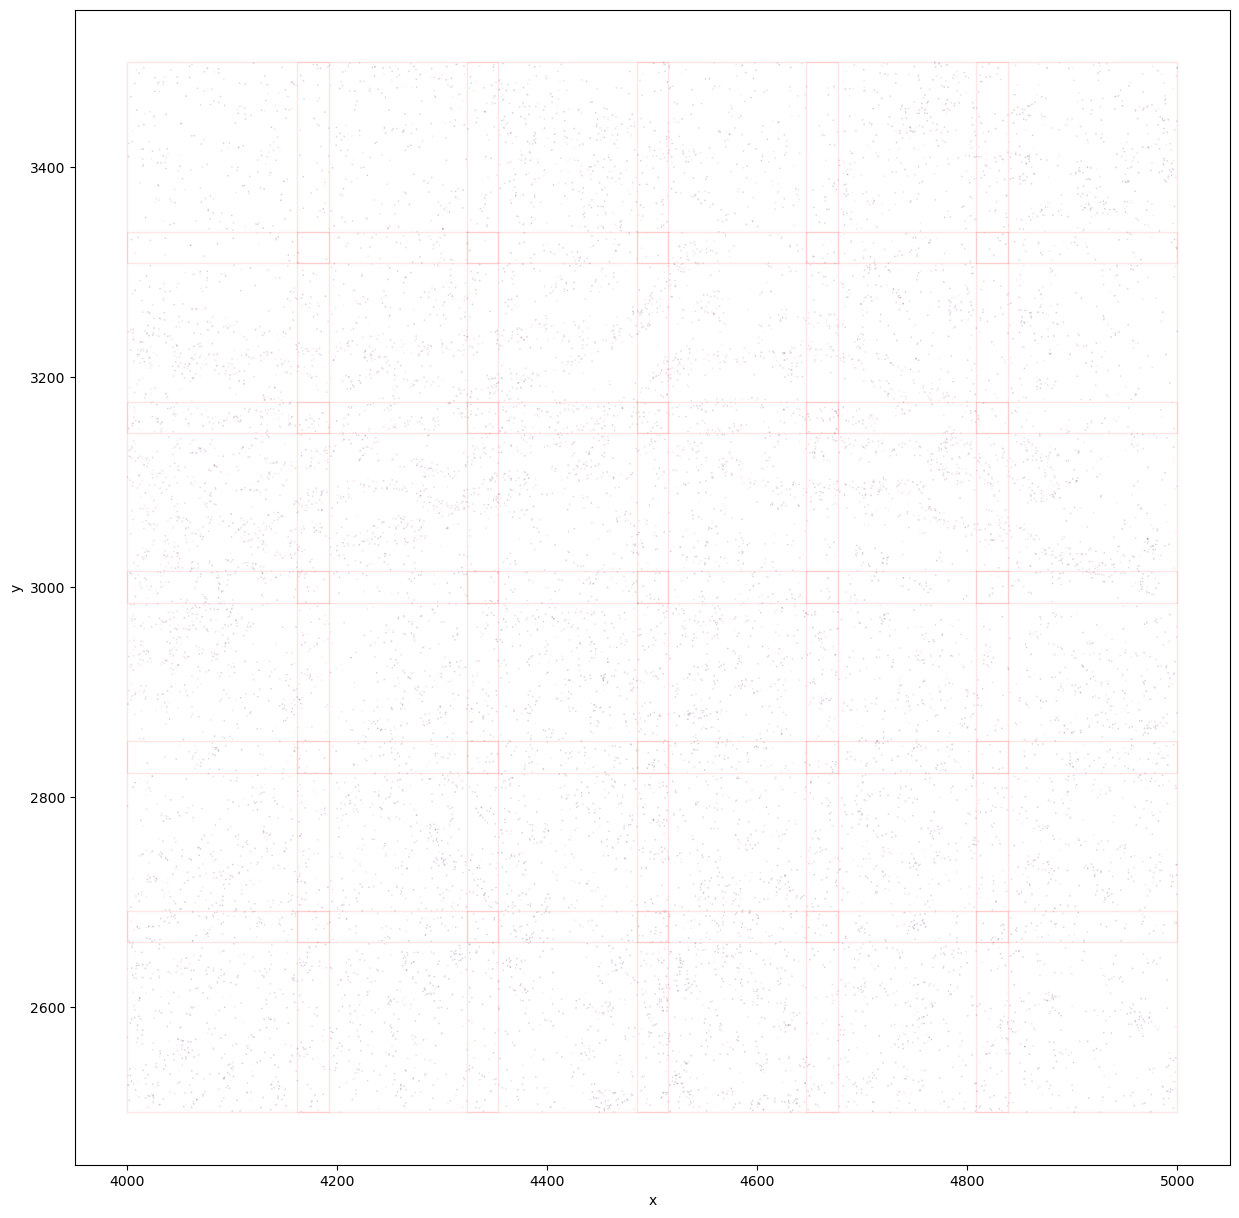

In [18]:
fig, ax = plt.subplots(figsize=(15, 15))
subtable[::200].scatter_plot(ax=ax)
for tile in tiles:
    tile.plot_rect(ax=ax, color=(1, 0, 0, 0.1))

In [19]:
# define a segmentation method
seg_method = sawg.segmentation.CellposeSegmentationMethod
seg_opts = dict(options={
    'region': None,
    'cellpose_model': path_to_model,
    'cellpose_gpu': 'auto',
    'px_size': 0.108,          # um / px
    'cell_dia': 10,            # um
    'z_plane_thickness': 1.5,  # um
    'images': {
        'cyto': {'channel': 'total_mrna', 'frame': 3}, 'nuclei': {'channel': 'DAPI', 'frame': 3}
    }, 
    'cellpose_options': {
        'batch_size': 8,
    },
})


In [20]:
# generate specifications for segmenting each tile on HPC
if not os.path.exists(tile_save_path):
    os.mkdir(tile_save_path)
run_spec = {}
for i,tile in enumerate(tiles):
    run_spec[i] = (
        sawg.segmentation.run_segmentation,
        (),
        dict(
            load_func=sawg.SpotTable.load_merscope,
            load_args=dict(
                csv_file=csv_file,
                cache_file=cache_file,
                image_path=image_path,
            ),
            subregion=tile.parent_region,  # each array job will pick from a different region
            method_class=seg_method,
            method_args=seg_opts,
            result_file=os.path.join(tile_save_path, f'segmentation_result_{i}.pkl'),
            cell_id_file=os.path.join(tile_save_path, f'segmentation_result_{i}.npy'),
        )
    )

print(f"Generated segmentation spec for {len(run_spec)} tiles")

Generated segmentation spec for 36 tiles


In [21]:
# run segmentation on all tiles
jobs = sawg.hpc.run_slurm_func(
    run_spec=run_spec,
    conda_env='//allen/ai/homedirs/madeleine.hewitt/miniconda3/envs/seg_demo/',
    hpc_host='localhost',
    job_path=job_path,
    partition='celltypes', 
    job_name='test-job',
    nodes=1,
    ntasks=1,
    array=f'0-{len(run_spec)-1}',
    mincpus=1,
    gpus_per_node=1,
    mem='20G',
    time='0:30:00',
    mail_user=None,    
)

In [22]:
# wait for jobs to finish
import time, os
from tqdm.notebook import tqdm
with tqdm(total=len(jobs)) as pbar:
    while True:
        finished = [j for j in jobs if os.path.exists(j.output_file)]
        n_finished = len(finished)
        pbar.update(n_finished - pbar.n)
        print(f'{n_finished} / {len(jobs)}  {jobs.state_counts()}')
        time.sleep(60)
        if n_finished == len(jobs):
            break


  0%|          | 0/36 [00:00<?, ?it/s]

1 / 36  {'NO': 35, 'R': 1}
3 / 36  {'NO': 33, 'R': 3}
14 / 36  {'NO': 24, 'R': 12}
21 / 36  {'NO': 24, 'R': 12}
26 / 36  {'NO': 24, 'R': 12}
34 / 36  {'NO': 22, 'PD': 2, 'R': 12}
36 / 36  {'NO': 29, 'R': 7}


In [23]:
# merge results back together

subtable.cell_ids = np.empty(len(subtable), dtype=int)
subtable.cell_ids[:] = -1

merge_results = []

skipped = []
for i,tile_spec in enumerate(tqdm(run_spec.values())):
    cell_id_file = tile_spec[2]['cell_id_file']
    if not os.path.exists(cell_id_file):
        print(f"Skipping tile {i} : no cell ID file generated")
        skipped.append(i)
        continue
    tile = tiles[i]
    tile.cell_ids = np.load(cell_id_file)
    result = subtable.merge_cells(tile, padding=5)
    merge_results.append(result)

  0%|          | 0/36 [00:00<?, ?it/s]

In [24]:
for i in skipped:
    print(jobs[i].error)
    print(jobs[i].output)

In [25]:
# save segmented cell IDs
np.save(segmentation_file, subtable.cell_ids)
print("Saved to", segmentation_file)

Saved to /allen/programs/celltypes/workgroups/rnaseqanalysis/NHP_spatial/seg_tests/mouse_658850_testdata_image12/segmentation.npy


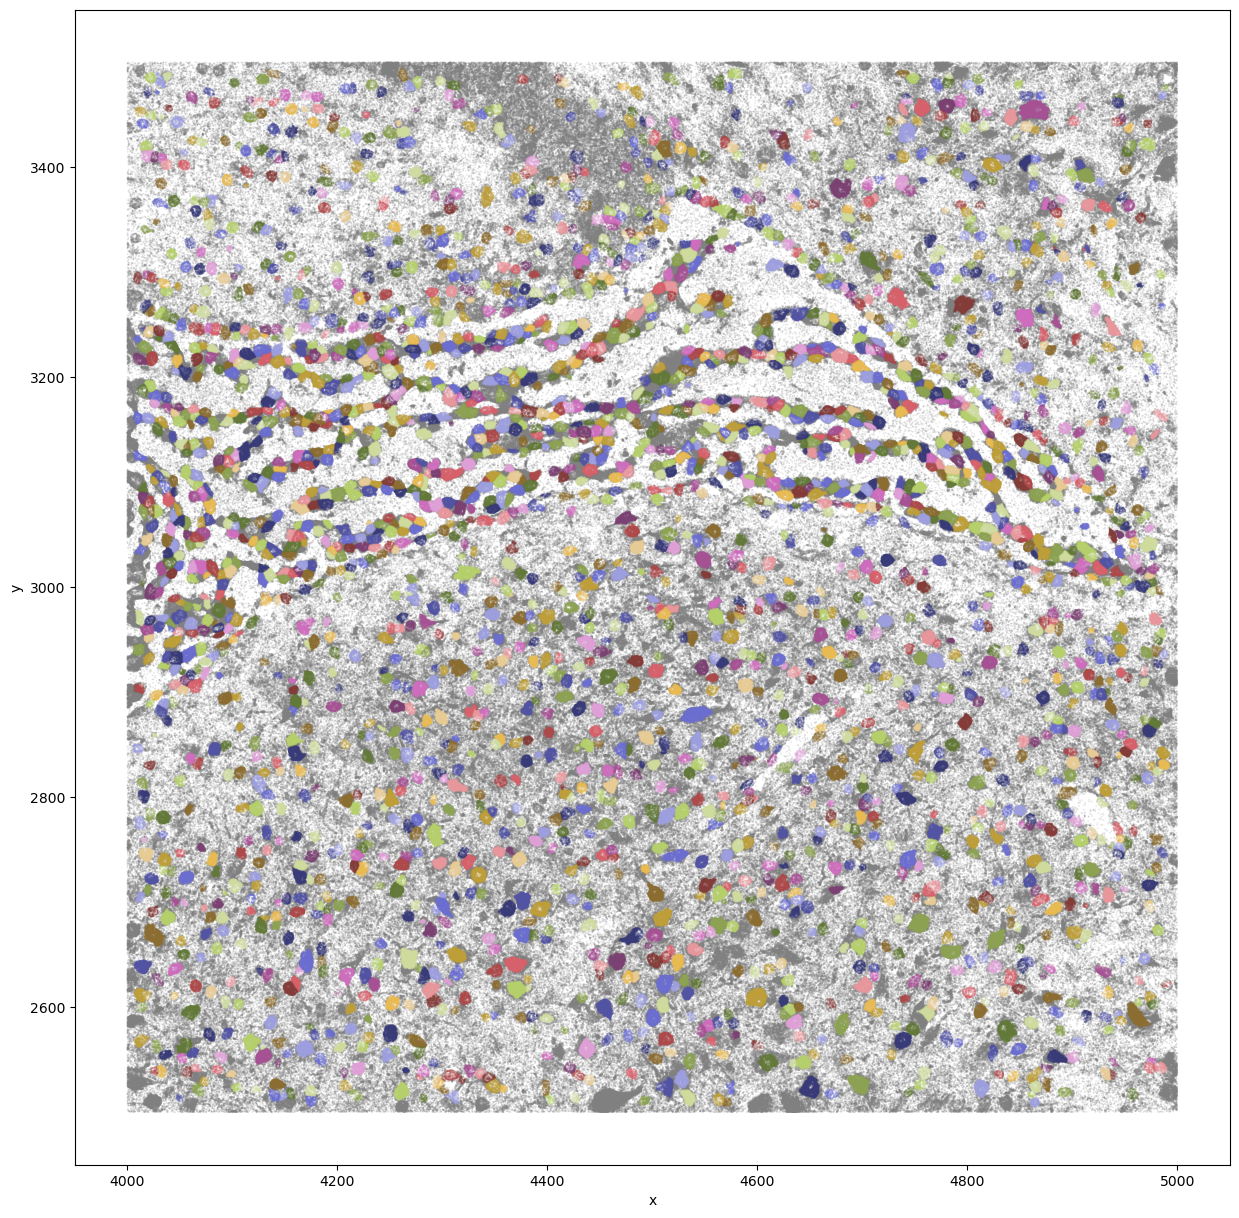

In [26]:
fig,ax = plt.subplots(figsize=(15, 15))
subtable.scatter_plot(ax=ax, color='cell')

## Save cell by gene table

In [30]:
# for 2D segmentation, specify z if you want the cell by gene table for just one frame
# cell_by_gene_ad = subtable[subtable.z == 3].cell_by_gene_anndata()

# otherwise, the cell by gene table will be for the 2D segmentation projected to all z
cell_by_gene_ad = subtable.cell_by_gene_anndata()

Generating cell x gene table...
Counting genes...


  0%|          | 0/2802766 [00:00<?, ?it/s]

Generating sparse matrix...


  0%|          | 0/2907 [00:00<?, ?it/s]

Calculating cell centroids...


/home/madeleine.hewitt/miniconda3/envs/seg_demo/lib/python3.11/site-packages/anndata/_core/anndata.py:864: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [-1, 7, 8, 9, 10]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")


In [31]:
adata.write(anndata_file)

## (Optional) Delete intermediate results files

Running this cell will delete the pkl files generated by segmenting individual tiles. Although these can sometimes be useful for inspecting intermediate results (e.g. Cellpose predicted flows, total mRNA images), they take up a lot of disk space. 

**ONLY** run this cell if the segmentation of all tiles is complete and you are sure you do not need the pkl files anymore.

In [40]:
# False by default to prevent accidental file deletion if someone runs all cells
# Set to True if you wish to delete them
remove_pkl_files = False

if remove_pkl_files:
    files_to_remove = glob.glob(f'{tile_save_path}/segmentation_result_*.pkl')
    for file in files_to_remove:
        os.remove(file)